Install additional packages

In [1]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-si9won3r
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-si9won3r
  Resolved https://github.com/tensorflow/docs to commit 7d9aab3abb979d304e768df250b7fd069d60497e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184416 sha256=3550c880caf12911fbef3491cc16220e994d6e30d18fa541684dab4678a04981
  Stored in directory: /tmp/pip-ephem-wheel-cache-5j61j100/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Imports

In [2]:
import glob
import matplotlib.pyplot as plt
import imageio
import numpy as np
import os
import PIL
import time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

from IPython import display


Parameters

In [3]:
plt.rcParams["figure.figsize"] = (7,7)

In [4]:
IMAGE_SHAPE=(32,32,3)

# Dataset

load dataset

In [5]:
(y_train, _), (y_test,_) = tf.keras.datasets.cifar10.load_data()
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
y_train = (y_train) / 255.  # Normalize the images to [0, 1]
y_test = (y_test) / 255.  # Normalize the images to [0, 1]

170498071/170498071 [==============================] - 15s 0us/step


cutout 

In [6]:
x_train = tf.identity(y_train)
x_test = tf.identity(y_test)

In [7]:
class RandomCutout():
  def __init__(self, mask_size=(16,16), border=(0,0), name = 'random_cutout', **kwargs):
    super(RandomCutout, self).__init__(**kwargs)
    
    self.mask_size = mask_size
    self.border = border

  def __call__(self, image_batch):
      x = tf.shape(image_batch)[1]
      y = tf.shape(image_batch)[2]

      xoffset = tf.cast(tf.math.ceil(self.mask_size[0] / 2.) + self.border[0], dtype=tf.int32)
      yoffset = tf.cast(tf.math.ceil(self.mask_size[1] / 2.) + self.border[1], dtype=tf.int32)
      xmin, xmax = xoffset, x - xoffset
      ymin, ymax = yoffset, y - yoffset

      if xmin < xmax:
        xoffset = tf.random.uniform(shape=[], minval=xmin, maxval=xmax, dtype=tf.dtypes.int32)
      else:
        xoffset = tf.cast(x / 2, dtype=tf.int32)
      if ymin < ymax:
        yoffset = tf.random.uniform(shape=[], minval=ymin, maxval=ymax, dtype=tf.dtypes.int32)
      else:
        yoffset = tf.cast(y / 2, dtype=tf.int32)

      xmin, xmax = xoffset - tf.cast(tf.math.ceil(self.mask_size[0] / 2.), dtype=tf.int32), xoffset + tf.cast(tf.math.ceil(self.mask_size[0] / 2.), dtype=tf.int32)
      ymin, ymax = yoffset - tf.cast(tf.math.ceil(self.mask_size[1] / 2.), dtype=tf.int32), yoffset + tf.cast(tf.math.ceil(self.mask_size[1] / 2.), dtype=tf.int32)

      mask = tfa.image.cutout(tf.zeros_like(image_batch), mask_size=self.mask_size, offset=(yoffset,xoffset), constant_values=1.)
      context = image_batch * (1 - mask)
      random_block = image_batch * mask
      return context, random_block, mask, (ymin, xmin, ymax-ymin, xmax-xmin)

In [8]:
random_cutout = RandomCutout(mask_size=(16,16), border=(2,2))

Input


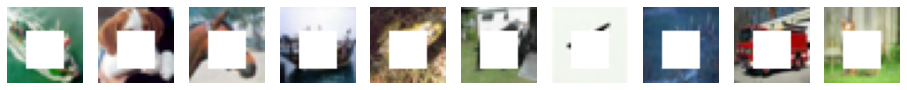

Block


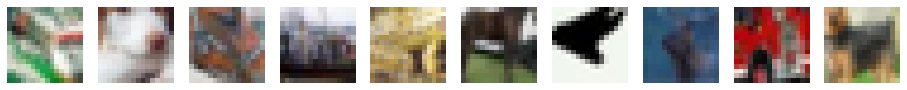

Mask


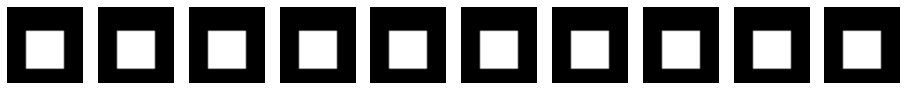

In [9]:
y_batch = y_test[15:25]
context, random_block, mask, coords = random_cutout(y_batch)

fig = plt.figure(figsize=(16,160))
print("Input")
for i, img in enumerate(context + mask):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(16,160))
print("Block")
block = tf.image.crop_to_bounding_box(random_block, *coords)
for i, img in enumerate(block):
    plt.subplot(1,10 ,i+1)
    plt.imshow((img))
    plt.axis('off')

plt.show()

fig = plt.figure(figsize=(16,160))
print("Mask")
for i, img in enumerate(mask):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


# Models


## generator

In [26]:
def Generator(input_shape=(32,32,3)):
    inputs = layers.Input(input_shape)
    # PART I
    # Encoder
    x = layers.Conv2D(32, (5,5), strides=1, padding="same", name="conv1", activation=tf.keras.activations.elu)(inputs) 
    x = layers.Conv2D(64, (4,4), strides=2, padding="same", name="conv2", activation=tf.keras.activations.elu)(x) 
    x = layers.Conv2D(64, (3,3), strides=1, padding="same", name="conv3", activation=tf.keras.activations.elu)(x)
    x = layers.Conv2D(128, (3,3), strides=2, padding="same", name="conv4", activation=tf.keras.activations.elu)(x)
    x = layers.Conv2D(128, (3,3), strides=1, padding="same", name="conv5", activation=tf.keras.activations.elu)(x)
    x = layers.Conv2D(128, (3,3), strides=1, padding="same", name="conv6", activation=tf.keras.activations.elu)(x)

    # dilation convolutions
    x = layers.Conv2D(128, (3,3), strides=1, dilation_rate=(2,2), padding="same", name="dilation_conv1", activation=tf.keras.activations.elu)(x)
    x = layers.Conv2D(128, (3,3), strides=1, dilation_rate=(4,4) ,padding="same", name="dilation_conv2", activation=tf.keras.activations.elu)(x)
    # x = layers.Conv2D(128, (3,3), strides=1, dilation_rate=(8,8) ,padding="same", name="dilation_conv3", activation=tf.keras.activations.elu)(x)
    # x = layers.Conv2D(128, (3,3), strides=1, dilation_rate=(16,16) ,padding="same", name="dilation_conv4", activation=tf.keras.activations.elu)(x)

    # PART II
    # Decoder
    x = layers.Conv2D(128, (3,3), strides=1, padding='same', name="deconv1", activation=tf.keras.activations.elu)(x)
    x = layers.Conv2D(128, (3,3), strides=1, padding='same',name="deconv2", activation=tf.keras.activations.elu)(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)


    x = layers.Conv2D(64, (3,3), strides=1, padding='same',name="deconv3", activation=tf.keras.activations.elu)(x)
    x = layers.Conv2D(64, (3,3), strides=1, padding='same',name="deconv4", activation=tf.keras.activations.elu)(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')(x)

    x = layers.Conv2D(32, (3,3), strides=1, padding='same',name="deconv5", activation=tf.keras.activations.elu)(x)
    x = layers.Conv2D(16, (3,3), strides=1, padding='same',name="deconv6", activation=tf.keras.activations.elu)(x)

    x = layers.Conv2D(3, (3,3), strides=1, padding='same',name="deconv7")(x)  
    outputs = tf.clip_by_value(x, 0., 1.) # obcinają wartości zamiast używać funkcji aktywacji typu tanh czy sigmooid
    model = tf.keras.Model(inputs, outputs, name="Generator")

    return model

generator = Generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        2432      
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        32832     
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 conv4 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 conv5 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 conv6 (Conv2D)              (None, 8, 8, 128)         14

## discriminator

In [14]:
def LocalCritic(input_shape=(16,16,3)):
    inputs = layers.Input((input_shape))
    x = layers.Conv2D(64, (5,5), strides=2, padding="same", )(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (5,5), strides=2, padding="same", )(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, (5,5), strides=2, padding="same", )(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, (5,5), strides=1, padding="same", )(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="LocalCritic")
    return model

local_critic = LocalCritic()
local_critic.summary()

Model: "LocalCritic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          4864      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         204928    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 256)         819456    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 2, 2, 256)         

In [15]:
def GlobalCritic(input_shape=(32,32,3)):
    inputs = layers.Input((input_shape))
    x = layers.Conv2D(64, (5,5), strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (5,5), strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, (5,5), strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, (5,5), strides=1, padding="same",)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="LocalCritic")
    return model

global_critic = GlobalCritic()
global_critic.summary()

Model: "LocalCritic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 4, 4, 256)         

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 8, 8, 64)     4864        ['input_8[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 16, 16, 64)   4864        ['input_9[0][0]']                
                                                                                      

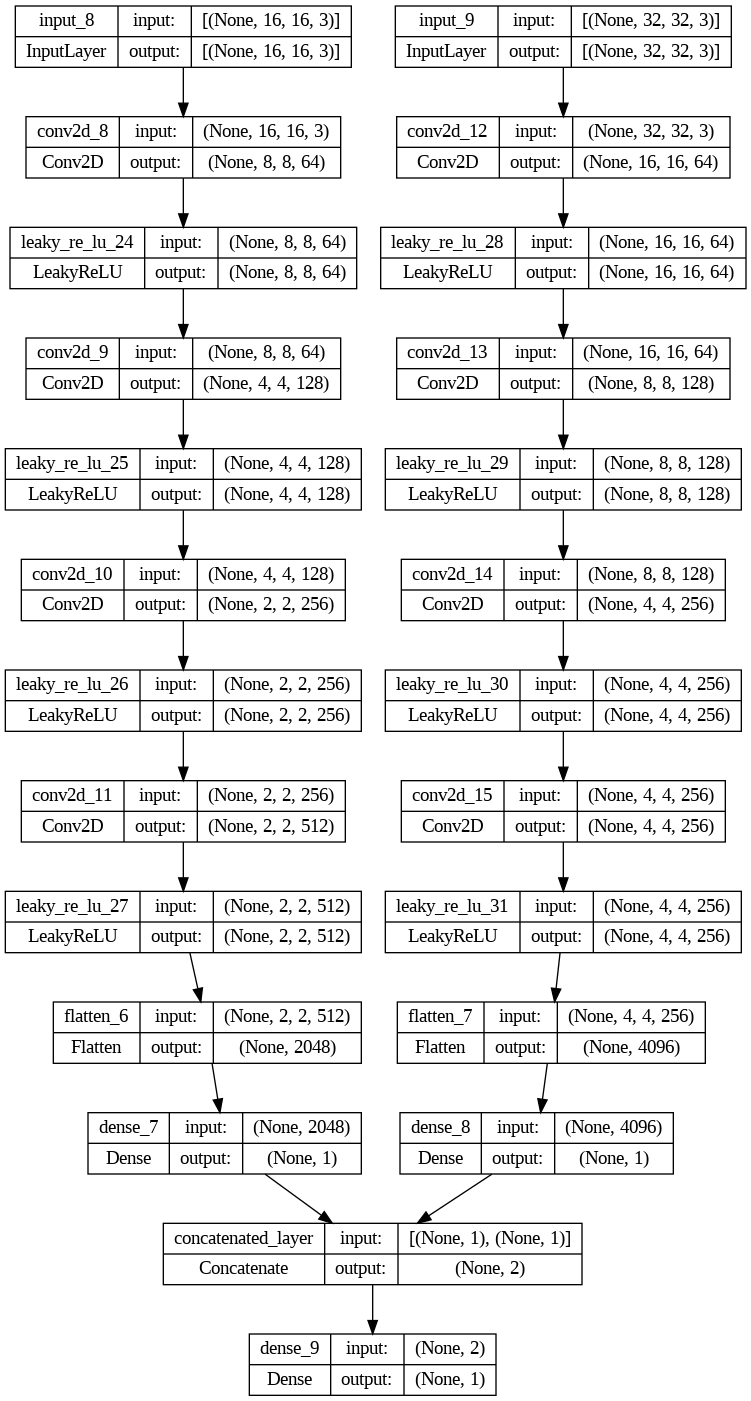

In [16]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


def Discriminator(ldiscriminator, gdiscriminator):
  ld = ldiscriminator
  gd = gdiscriminator

  #Final Layer
  x = layers.Concatenate()([ld.output, gd.output])
  output_layer = layers.Dense(1, activation = "sigmoid")(x)

  #Model Definition 
  model = tf.keras.Model(inputs=[(ld.inputs,gd.inputs)], outputs=output_layer, name = "discriminator")
  return model
  
discriminator = Discriminator(LocalCritic(), GlobalCritic())
discriminator.summary()
plot_model(discriminator, "discriminator_architecture.png", show_shapes=True)

Input


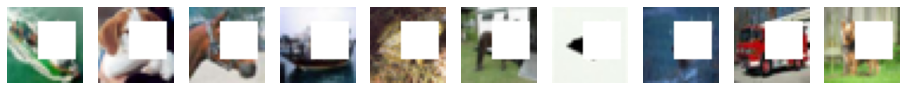

Block


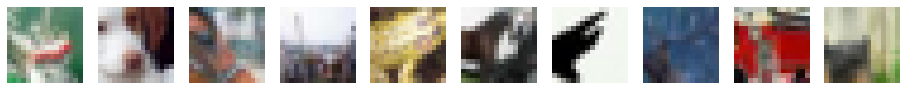

Mask


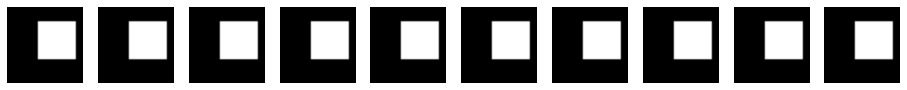

Output


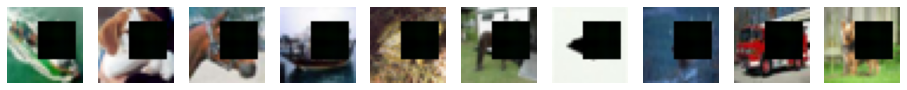

In [17]:
test_batch = y_test[15:25]
context, random_block, mask, coords = random_cutout(test_batch)
context_white = context + mask
inpainted = context + generator(context_white)*mask

fig = plt.figure(figsize=(16,160))
print("Input")
for i, img in enumerate(context + mask):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(16,160))
print("Block")
block = tf.image.crop_to_bounding_box(random_block, *coords)
for i, img in enumerate(block):
    plt.subplot(1,10 ,i+1)
    plt.imshow((img))
    plt.axis('off')

plt.show()

fig = plt.figure(figsize=(16,160))
print("Mask")
for i, img in enumerate(mask):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


fig = plt.figure(figsize=(16,160))
print("Output")
for i, img in enumerate(inpainted):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()



## metrics

In [18]:
class psnr_metric(tf.keras.metrics.Metric):
    def __init__(self, name = 'psnr', **kwargs):
        super(psnr_metric, self).__init__(**kwargs)
        self.value = self.add_weight('value', initializer = 'zeros')
        self.count = self.add_weight('count', initializer = 'zeros')

    def update_state(self, y_true, y_pred,sample_weight=None):
        self.value.assign_add(tf.reduce_mean(tf.image.psnr(y_true, y_pred, 2)))
        self.count.assign_add(1)

    def reset_state(self):
        self.value.assign(0)
        self.count.assign(0)

    def result(self):
        return self.value / self.count

psnr = psnr_metric()

test_batch = y_test[:25]
context, random_block, mask, cords = random_cutout(test_batch)

reconstructed = context+generator(context)*mask


psnr(test_batch,reconstructed)

<tf.Tensor: shape=(), dtype=float32, numpy=18.141478>

In [19]:
class ssim_metric(tf.keras.metrics.Metric):
    def __init__(self, name = 'ssim', **kwargs):
        super(ssim_metric, self).__init__(**kwargs)
        self.value = self.add_weight('value', initializer = 'zeros')
        self.count = self.add_weight('count', initializer = 'zeros')

    def update_state(self, y_true, y_pred,sample_weight=None):
        self.value.assign_add(tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2)))
        self.count.assign_add(1)

    def reset_state(self):
        self.value.assign(0)
        self.count.assign(0)

    def result(self):
        return self.value / self.count

ssim = ssim_metric()

test_batch = y_test[:25]
context, random_block, mask, cords = random_cutout(test_batch)
reconstructed = context+generator(context)*mask

ssim(test_batch,reconstructed)

<tf.Tensor: shape=(), dtype=float32, numpy=0.48461577>

# Context encoder class

In [50]:
class WGAN(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self, 
                  discriminator,
                  generator,
                  generator_extra_steps=1,
                  discriminator_extra_steps=1,
                  mask_size=(16,16),
                  border=(2,2),
                  gp_weight=10.0,
                  name="wgan"):
      super(WGAN, self).__init__()

      self.discriminator = discriminator
      self.generator = generator

      self.d_steps = discriminator_extra_steps
      self.g_steps = generator_extra_steps

      self.psnr_metric = psnr_metric(name="psnr")
      self.ssim_metric = ssim_metric(name="ssim")
      self.gp_weight = gp_weight

      self.random_cutout = RandomCutout(mask_size, border)


    def compile(self, generator_optimizer, discriminator_optimizer, discriminator_loss, adversarial_loss, reconstruction_loss, lam=0.99):
      super(WGAN, self).compile()
      self.generator_optimizer = generator_optimizer
      self.discriminator_optimizer = discriminator_optimizer
      self.adversarial_loss = adversarial_loss
      self.reconstruction_loss = reconstruction_loss
      self.discriminator_loss = discriminator_loss
      self.lam = lam

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        # metrics = super().metrics
        # metrics.append(self.psnr_metric)
        return [self.psnr_metric, self.ssim_metric]

    def gradient_penalty(self, batch_size, real_images, real_block, fake_images, fake_block):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        diff1 = fake_block - real_block
        interpolated = real_images + alpha * diff
        interpolated1 = real_block + alpha * diff1

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator([interpolated1, interpolated], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        # norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))  # collapse
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3])+1e-12)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @tf.function
    def test_step(self, data):
      if isinstance(data, tuple):
            x_batch = data[0]
            y_batch = data[1]

      context, random_region, mask, coords = self.random_cutout(x_batch)
      context_white = context + mask
      real_images = y_batch
      batch_size = tf.shape(y_batch)[0]

      # Generate fake images from the latent vector
      generated = self.generator(context_white, training=False)
      fake_images = context + generated * mask

      fake_block = tf.image.crop_to_bounding_box(fake_images, *coords)
      real_block = tf.image.crop_to_bounding_box(real_images, *coords)
      # Get the logits for the fake images
      fake_logits = self.discriminator([fake_block, fake_images], training=False)
      # Get the logits for the real images
      real_logits = self.discriminator([real_block, real_images], training=False)

      # Calculate the discriminator loss using the fake and real image logits
      d_cost = self.discriminator_loss(real_logits, fake_logits)
      # Calculate the gradient penalty
      gp = self.gradient_penalty(batch_size,real_images, real_block, fake_images, fake_block)
      # Add the gradient penalty to the original discriminator loss
      d_loss = d_cost + gp * self.gp_weight

      # Calculate the generator loss
      g_loss = self.lam * self.reconstruction_loss(real_block, fake_block) + (1-self.lam) * self.adversarial_loss(fake_logits)

      self.psnr_metric.update_state(real_images,fake_images)
      self.ssim_metric.update_state(real_images,fake_images)
      return {"g_loss": g_loss,"d_loss": d_loss, "psnr": self.psnr_metric.result(), "ssim": self.ssim_metric.result()}


    @tf.function
    def train_step(self, data):
      if isinstance(data, tuple):
            x_batch = data[0]
            y_batch = data[1]

      context, random_region, mask, coords = self.random_cutout(x_batch)
      context_white = context + mask
      real_images = y_batch
      batch_size = tf.shape(y_batch)[0]

      for i in range(self.d_steps):
        with tf.GradientTape() as tape:
          # Generate fake images from the latent vector
          generated = self.generator(context_white, training=True)
          fake_images = context + generated * mask

          fake_block = tf.image.crop_to_bounding_box(fake_images, *coords)
          real_block = tf.image.crop_to_bounding_box(real_images, *coords)
          # Get the logits for the fake images
          fake_logits = self.discriminator([fake_block, fake_images], training=True)
          # Get the logits for the real images
          real_logits = self.discriminator([real_block, real_images], training=True)

          # Calculate the discriminator loss using the fake and real image logits
          d_cost = self.discriminator_loss(real_logits, fake_logits)
          # Calculate the gradient penalty
          gp = self.gradient_penalty(batch_size,real_images, real_block, fake_images, fake_block)
          # Add the gradient penalty to the original discriminator loss
          d_loss = d_cost + gp * self.gp_weight

        # Get the gradients w.r.t the discriminator loss
        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update the weights of the discriminator using the discriminator optimizer
        self.discriminator_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

      for i in range(self.g_steps):
        with tf.GradientTape() as tape:
          generated = self.generator(context_white, training=True)
          fake_images = context + generated * mask
          fake_block = tf.image.crop_to_bounding_box(fake_images, *coords)
          real_block = tf.image.crop_to_bounding_box(real_images, *coords)
          # Get the discriminator logits for fake images
          gen_img_logits = self.discriminator([fake_block, fake_images], training=True)
          # Calculate the generator loss
          g_loss = self.lam * self.reconstruction_loss(real_block, fake_block) + (1-self.lam) * self.adversarial_loss(fake_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.generator_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

      # Compute our own metrics
      self.psnr_metric.update_state(real_images,fake_images)
      self.ssim_metric.update_state(real_images,fake_images)
      return {"g_loss": g_loss,"d_loss": d_loss, "psnr": self.psnr_metric.result(), "ssim": self.ssim_metric.result()}

# Compile

## loss

In [28]:
test_batch = y_test[:25]
context, random_region, mask, coords = random_cutout(test_batch)
reconstructed = context+generator(context)*mask

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()


In [31]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

fake_block = tf.image.crop_to_bounding_box(reconstructed, *coords)
real_block = tf.image.crop_to_bounding_box(test_batch, *coords)
discriminator_loss(discriminator([real_block, test_batch], training=False), discriminator([fake_block, reconstructed], training=False))

<tf.Tensor: shape=(), dtype=float32, numpy=-8.252263e-05>

In [32]:
def adv_loss(fake_preds):
  return cross_entropy(tf.ones_like(fake_preds), fake_preds)

def rec_loss(y_true, y_pred):
  # return mse(y_true, y_pred)     # MSE / L2
  return mae(y_true, y_pred)  # MAE / L1

In [34]:
LAM = 0.999

fake_block = tf.image.crop_to_bounding_box(reconstructed, *coords)
real_block = tf.image.crop_to_bounding_box(test_batch, *coords)
# generator_loss(discriminator(fake_block, training=False), test_batch, reconstructed)
generator_loss =  LAM * rec_loss(real_block, fake_block) + (1 - LAM) * adv_loss(discriminator([fake_block, reconstructed], training=False))
print(generator_loss)

tf.Tensor(0.43858156, shape=(), dtype=float32)


## optimizers

In [57]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)

LR = 0.00002
BETA1 = 0.9
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=BETA1)            # 3e-4
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=BETA1)       # 3e-5

## model compile

In [58]:
MASK_SIZE = (16,16)
BORDER = (2,2)
wgan = WGAN(discriminator=Discriminator(LocalCritic(), GlobalCritic()), 
                         generator= Generator(),
                         discriminator_extra_steps=2, gp_weight=10,
                         mask_size=MASK_SIZE,
                         border=BORDER)

wgan.compile(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    discriminator_loss=discriminator_loss,
    adversarial_loss = adv_loss,
    reconstruction_loss=rec_loss,
    lam = 0.99)

# Training

In [59]:
images_to_show = x_test[:25]
print(images_to_show.shape)

(25, 32, 32, 3)


In [60]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, images_to_show=None, save_every=1,mask_size=(16,16),border=(8,8)):
        self.images_to_show = images_to_show
        self.save_every = save_every
        self.random_cutout = RandomCutout(mask_size, border)
        print(self.images_to_show.shape)

    def on_epoch_end(self, epoch, logs=None):
      if (epoch + 1) % self.save_every == 0:
        
        context, random_region, mask, coords = self.random_cutout(self.images_to_show)
        
        context_white = context + mask
        generated = self.model.generator(context_white, training=False)

        reconstructed_images = context + generated * mask

        plt.ioff()
        fig = plt.figure()
        plt.suptitle(f"epoch:{epoch+1}")
        for i in range(reconstructed_images.shape[0]):
            plt.subplot(5,5, i+1)
            plt.imshow(reconstructed_images[i])
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
        plt.close(fig)

show_images = GANMonitor(images_to_show=images_to_show, save_every=1, mask_size=(16,16), border=(8,8))

(25, 32, 32, 3)


In [61]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.discriminator_optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.discriminator_optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.discriminator_optimizer.lr, scheduled_lr)
        if scheduled_lr != lr:
          print("\nEpoch %d: Learning rate is %6.4f." % (epoch+1, scheduled_lr))

LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    # (1, 0.0),
    (100, 1e-7),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [62]:
EPOCHS = 30
BATCH_SIZE = 128
history = wgan.fit(x=x_train,
                      y=y_train,
                      validation_data=(x_test, y_test),
                      epochs=EPOCHS, 
                      initial_epoch = 0,
                      batch_size = BATCH_SIZE,
                      shuffle=True, 
                      callbacks=[show_images, CustomLearningRateScheduler(lr_schedule)])

Epoch 1/30
391/391 [==============================] - 113s 272ms/step - g_loss: 0.1882 - d_loss: 1.5605 - psnr: 24.4789 - ssim: 0.5953 - val_g_loss: 0.1848 - val_d_loss: 0.3156 - val_psnr: 26.7370 - val_ssim: 0.6613
Epoch 2/30
391/391 [==============================] - 105s 269ms/step - g_loss: 0.1639 - d_loss: -0.0592 - psnr: 26.5817 - ssim: 0.6619 - val_g_loss: 0.1746 - val_d_loss: -0.1552 - val_psnr: 25.6701 - val_ssim: 0.6493
Epoch 3/30
391/391 [==============================] - 105s 269ms/step - g_loss: 0.1596 - d_loss: -0.1309 - psnr: 26.8013 - ssim: 0.6668 - val_g_loss: 0.1889 - val_d_loss: -0.2189 - val_psnr: 27.0595 - val_ssim: 0.6852
Epoch 4/30
391/391 [==============================] - 105s 269ms/step - g_loss: 0.1541 - d_loss: -0.1852 - psnr: 27.0832 - ssim: 0.6794 - val_g_loss: 0.1629 - val_d_loss: -0.2328 - val_psnr: 27.2691 - val_ssim: 0.6960
Epoch 5/30
391/391 [==============================] - 105s 268ms/step - g_loss: 0.1515 - d_loss: -0.2150 - psnr: 27.3606 - ssim: 0

# Visualization

## plots

In [63]:
## Plot train and validation curves
g_loss = history.history['g_loss']
val_g_loss =  history.history['val_g_loss']

d_loss =  history.history['d_loss']
val_d_loss =  history.history['val_d_loss']

psnr =  history.history['psnr']
val_psnr =  history.history['val_psnr']

ssim =  history.history['ssim']
val_ssim =  history.history['val_ssim']

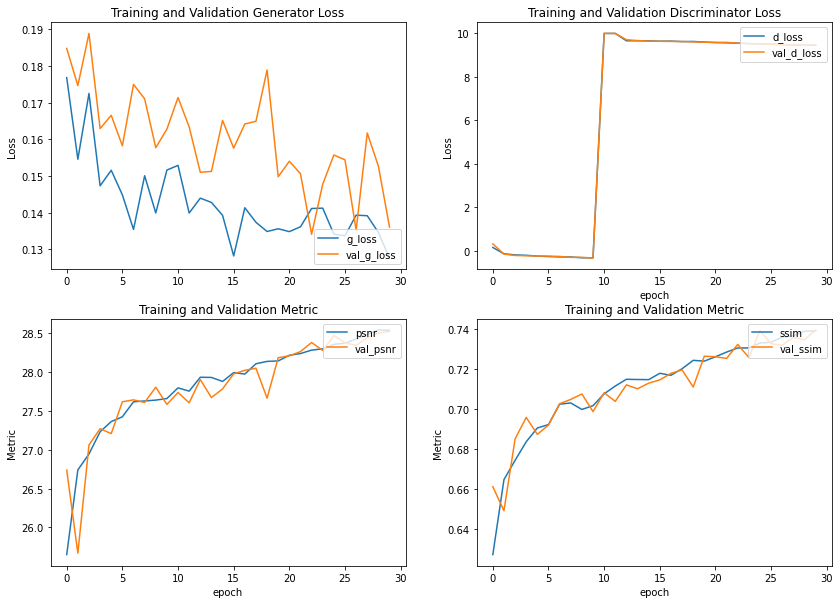

In [64]:
plt.figure(figsize=(14,10))
plt.subplot(2, 2, 1)
plt.plot(g_loss, label='g_loss')
plt.plot(val_g_loss, label='val_g_loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
# plt.ylim([0,.1])
plt.title('Training and Validation Generator Loss')

plt.subplot(2, 2, 2)
plt.plot(d_loss, label='d_loss')
plt.plot(val_d_loss, label='val_d_loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,2])
plt.title('Training and Validation Discriminator Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(psnr, label='psnr')
plt.plot(val_psnr, label='val_psnr')
plt.legend(loc='upper right')
plt.ylabel('Metric')
# plt.ylim([25, 30])
plt.title('Training and Validation Metric')
plt.xlabel('epoch')


plt.subplot(2,2, 4)
plt.plot(ssim, label='ssim')
plt.plot(val_ssim, label='val_ssim')
plt.legend(loc='upper right')
plt.ylabel('Metric')
# plt.ylim([0,1])
plt.title('Training and Validation Metric')
plt.xlabel('epoch')

plt.show()

## last epoch output

In [65]:
history.epoch[-1]

29

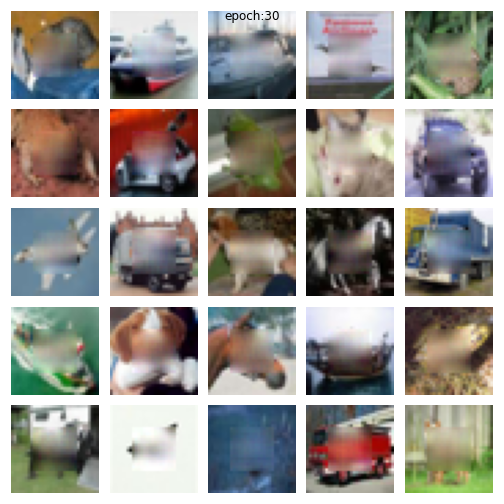

In [66]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(history.epoch[-1]+1)

## gif

In [67]:
anim_file = 'dcgan.gif'

filenames = glob.glob('image*.png')
filenames = sorted(filenames)
frames = []
for i,filename in enumerate(filenames):
  if i % 1 == 0:
    image = imageio.imread(filename)
    frames.append(image)
imageio.mimsave(anim_file, frames, format='GIF', fps=4)



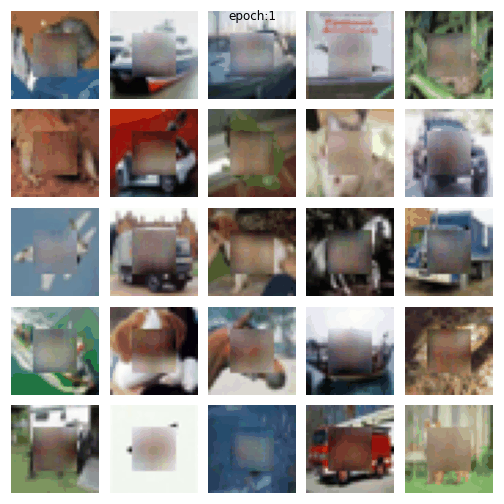

In [68]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
